In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from termcolor import colored
from mlxtend.evaluate import bias_variance_decomp
from sklearn.model_selection import learning_curve


In [30]:
def ROC(X_test,y_test,model):
    y_pred_proba = model.predict_proba(X_test)
    lr_probs = y_pred_proba[:,1]
    ns_probs = [0 for _ in range(len(y_test))]
    ns_auc = metrics.roc_auc_score(y_test, ns_probs)
    lr_auc = metrics.roc_auc_score(y_test, lr_probs)
    ns_fpr, ns_tpr, thresholds  = metrics.roc_curve(y_test,ns_probs)
    lr_fpr, lr_tpr, thresholds = metrics.roc_curve(y_test, lr_probs)
    plt.plot(ns_fpr,ns_tpr,linestyle='--', label='No Skill')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='Naive Bayes')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()
    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print('Treeb: ROC AUC=%.3f' % (lr_auc))

# Importar Datos puros Tratados

In [31]:
data = pd.read_csv('./dataA.csv')
data.head(1)

,Netflows,p1_d,p2_d,p3_d,duration,max_d,min_d,#packets,Avg_bps,Avg_pps,...,p2_ip,p3_ip,p1_ib,p2_ib,p3_ib,First_Protocol_ICMP,First_Protocol_ICMP6,First_Protocol_TCP,First_Protocol_UDP,Type_mine
0,-0.084787,-0.68541,-0.244709,-0.196223,0.361252,-0.132463,-0.625504,-0.317443,-0.359303,-0.336093,...,-0.343648,-0.398552,-0.417145,-0.476095,-0.558694,0,0,1,0,0


# Modelo

In [32]:
best_feature_pure = ['Avg_bps','Avg_bpp' ,'Avg_pps','p3_ip','p3_ib']
y = data['Type_mine']
X = data[best_feature_pure]

# Holdout

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size = 0.7, test_size=0.3, random_state = 1234)

# Naïve Bayes

In [34]:
model = GaussianNB()
model = model.fit(X_train, y_train)

In [35]:
model.class_count_

array([1746., 1567.])

In [36]:
model.class_prior_

array([0.52701479, 0.47298521])

In [37]:
y_pred = model.predict(X_test)
y_pred

array([1, 1, 0, ..., 1, 1, 1], dtype=int64)

In [38]:
y_test.shape, y_pred.shape, y.shape, y_train.shape

((1420,), (1420,), (4733,), (3313,))

In [39]:
print("El modelo de Naïve Bayes se equivocó en %d de los %d registros que componen el dataset original"
      % ((y_test != y_pred).sum(), data.shape[0]))

El modelo de Naïve Bayes se equivocó en 304 de los 4733 registros que componen el dataset original


([<matplotlib.axis.YTick at 0x1715d8bc278>,
 <a list of 2 Text yticklabel objects>)

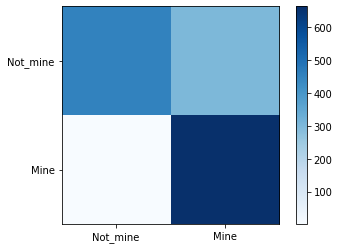

In [40]:
churm = metrics.confusion_matrix(y_test, y_pred)
plt.imshow(churm, cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Not_mine','Mine'])
plt.yticks(tick_marks, ['Not_mine','Mine'])

In [41]:
pd.DataFrame(churm)

,0,1
0,453,302
1,2,663


In [42]:
print("Exactitud: ", metrics.accuracy_score(y_test, y_pred))
print("Kappa: ", metrics.cohen_kappa_score(y_test, y_pred))

Exactitud:  0.7859154929577464
Kappa:  0.5813606167870824


In [43]:
print(colored('Metricas de los registros mineros', attrs=['bold']))

print("Precisión     : ", metrics.precision_score(y_test, y_pred, labels=[1], average='macro'))
print("Recall        : ", metrics.recall_score(y_test, y_pred, labels=[1], average='macro'))


VN = churm[0,0]
FP = churm[0,1]
specificity = VN/(VN+FP)

print("Especificidad : ", specificity)

print("F1-score      : ", metrics.f1_score(y_test, y_pred, labels=[1], average='macro'))

Metricas de los registros mineros
Precisión     :  0.6870466321243524
Recall        :  0.9969924812030075
Especificidad :  0.6
F1-score      :  0.8134969325153375


In [44]:
print(colored('Metricas de los registros no mineros', attrs=['bold']))


print("Precisión     : ", metrics.precision_score(y_test, y_pred, labels=[0], average='macro'))
print("Recall        : ", metrics.recall_score(y_test, y_pred, labels=[0], average='macro'))

VN = churm[1,1]
FP = churm[1,0]
specificity = VN/(VN+FP)

print("Especificidad : ", specificity)

print("F1-score      : ", metrics.f1_score(y_test, y_pred, labels=[0], average='macro'))

Metricas de los registros no mineros
Precisión     :  0.9956043956043956
Recall        :  0.6
Especificidad :  0.9969924812030075
F1-score      :  0.7487603305785124


In [45]:
mse, bias, var =  bias_variance_decomp(model, np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test), loss='mse', num_rounds=200, random_seed=1)
print('MSE: %.3f' % mse)
print('Bias: %.3f' % bias)
print('Variance: %.3f' % var)

MSE: 0.212
Bias: 0.209
Variance: 0.003


In [46]:
train_sizes, train_scores, test_scores = learning_curve(GaussianNB(), 
                                                        X, y,cv=10,scoring='accuracy')

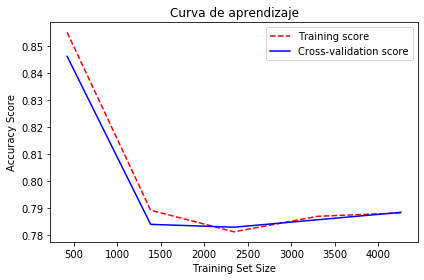

In [47]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, '--', color="red",  label="Training score")
plt.plot(train_sizes, test_mean, color="blue", label="Cross-validation score")

#plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="gray")
#plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="gray")

plt.title("Curva de aprendizaje")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

# Curva ROC

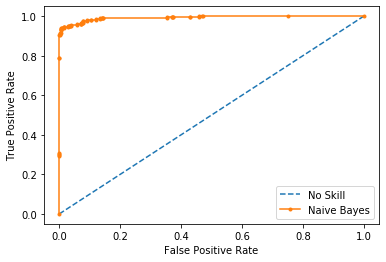

No Skill: ROC AUC=0.500
Treeb: ROC AUC=0.993


In [48]:
ROC(X_test,y_test,model)